In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa, librosa.display
import import_ipynb
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Lambda)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam

tf.reset_default_graph()

In [2]:
import preprocessing as prep
import constants as c

importing Jupyter notebook from preprocessing.ipynb
importing Jupyter notebook from audio_prep.ipynb
importing Jupyter notebook from constants.ipynb
importing Jupyter notebook from midi_prep.ipynb


In [3]:
def conv2d_reshape(cqt_matrices, midi_matrices):
    """
    Transpose both matrices (spectrogram and MIDI one-hot) to be in format [frames, frequency_bins/one-hot]
    and reshape given wav matrices into the right input shape for Keras Conv2D network: (batch, rows, cols, channels)
    
    Args:
    wav_matrices: array of CQT spectrograms (splitted into frames)
    midi_matrices: labels for frames, represented as one-hot vectors
    
    Return:
    Concatenated arrays of spectrograms and labels, which are used as input for neural network
    """
    
    cqt_reshaped = [np.array(cqt_chunk) for cqt_chunk in cqt_matrices]
    cqt_reshaped = np.concatenate(cqt_reshaped)
    cqt_reshaped = np.array([cqt.T for cqt in cqt_reshaped])
    cqt_reshaped = np.array([cqt.reshape(2*c.CHUNK_PADDING, c.BINS_NUMBER, 1) for cqt in cqt_reshaped])
    
    midi_reshaped = [midi_chunk.T for midi_chunk in midi_matrices]
    midi_reshaped = np.concatenate(midi_reshaped)  
    
    return cqt_reshaped, midi_reshaped

def create_conv_model(input_heigth, input_width, num_classes):
    """
    Create convolutional acoustic model inspired by Kelz 2016
    Paper: On The Potential Of Simple Framewise Approaches To Piano Transcription
    
    (Sequential) Model created using Keras high-level API: https://www.tensorflow.org/guide/keras
    
    Args:
    input_height/input_width: input parameters defining model shape
    num_classes: number of model output classes in Dense layer
    
    """
    
    input_shape = (input_heigth, input_width, 1)
    
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='valid', input_shape=input_shape))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='valid'))
    model.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2), padding='same'))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='valid'))
    model.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2), padding='same'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(num_classes, activation='sigmoid'))
    adam_opt = Adam(lr=0.0001, decay=1e-5)
    model.compile(loss='binary_crossentropy',
                  optimizer=adam_opt)
    return model

def create_classic_conv_model(input_heigth, input_width):
    """
    Create convolutional acoustic model for sequence predictions.
    
    Args:
    input_height/input_width: input parameters defining model shape

    Return:
    tf.keras.Model object with specific 
    input (batch, input_height, input_width, 1),
    output (batch, classes, width) shapes.
    """ 
    
    from tensorflow.keras.layers import Input
    
    inputs = Input(shape=(input_heigth, input_width, 1))
    model = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='valid')(inputs)
    model = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(model)
    model = MaxPooling2D(pool_size=(1, 2), strides=(3, 1), padding='valid')(model)
    model = Dropout(0.25)(model)
    model = Conv2D(filters=64, kernel_size=(1, 2), activation='relu', padding='valid')(model)
    model = Dropout(0.25)(model)
    model = Conv2D(filters=1, kernel_size=(1, 1), activation='relu', padding='same')(model)
    outputs = Lambda(lambda x: tf.keras.backend.squeeze(x, 3))(model)
#     model = Flatten()(model)
#     outputs = Dense(num_classes, activation='sigmoid')(model)
    
    return tf.keras.Model(inputs, outputs)
    

def train_model(cqt_train, cqt_test, midi_train, midi_test, n_classes=88):    
    height, width, depth = cqt_train[0].shape
    epochs = 5
    
    model = create_conv_model(height, width, n_classes)
    history = model.fit(cqt_train, midi_train, validation_data=(cqt_test, midi_test), epochs=epochs, batch_size=64)
    
    # Evaulation of accuracy and loss history
    # Inspiration from: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    return model

def generator_train_model(dataset, n_classes=88):    
    height, width = c.BINS_NUMBER, c.SEQUENCE_CHUNK_LENGTH + 2*c.CHUNK_PADDING
    epochs = 5
    
    model = create_conv_model(height, width, n_classes)
    model.summary()
    history = model.fit(dataset.make_one_shot_iterator(), steps_per_epoch=2)
    
    # Evaulation of accuracy and loss history
    # Inspiration from: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    return model

In [4]:
dataset1 = prep.get_dataset()

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


In [5]:
adam_opt = Adam(lr=0.0001, decay=1e-5)
model = create_classic_conv_model(264, 629)
model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(dataset1.make_one_shot_iterator(), epochs=10, steps_per_epoch=10)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 264, 629, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 262, 627, 16)      160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 262, 627, 32)      4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 88, 626, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 88, 626, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)    

10/10 [==============================] - 142s 14s/step - loss: 0.1020 - acc: 0.9675
Epoch 5/10
 1/10 [==>...........................] - ETA: 28s - loss: 0.1667 - acc: 0.9581Aligning single pair of CQT spectrogram and MIDI matrix
Both matrices aligned to 4677 frames.
 2/10 [=====>........................] - ETA: 1:10 - loss: 0.1320 - acc: 0.9691Aligning single pair of CQT spectrogram and MIDI matrix
Both matrices aligned to 5273 frames.
 3/10 [========>.....................] - ETA: 1:18 - loss: 0.1325 - acc: 0.9620Aligning single pair of CQT spectrogram and MIDI matrix
Both matrices aligned to 17855 frames.
 6/10 [=================>............] - ETA: 57s - loss: 0.1007 - acc: 0.9687 Aligning single pair of CQT spectrogram and MIDI matrix
Both matrices aligned to 7457 frames.
 7/10 [====================>.........] - ETA: 46s - loss: 0.0987 - acc: 0.9684Aligning single pair of CQT spectrogram and MIDI matrix
Both matrices aligned to 3517 frames.
 8/10 [=======================>......] - 

In [62]:
# model = generator_train_model(dataset1)

In [8]:
ws2 = np.array(prep.wav_chunks[0])
wavs_reshaped2 = np.array([w.T for w in ws2])
wsr2 = np.array([w.reshape(4, 264, 1) for w in wavs_reshaped2])
msr2 = prep.midi_chunks[0].T

In [75]:
midi_predicted = model.predict(cqt_m)

In [76]:
midi_predicted = midi_predicted.T

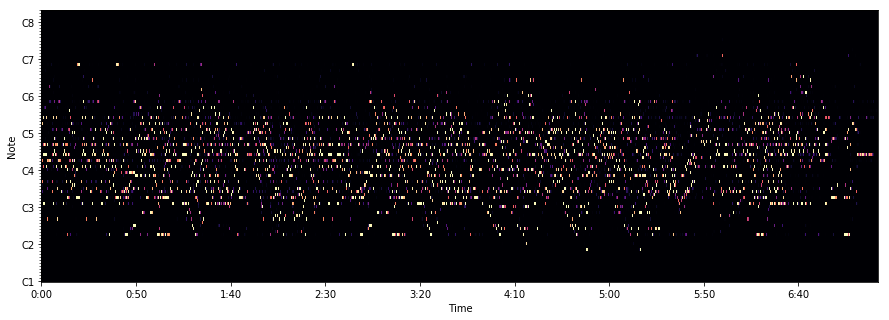

In [77]:
prep.mp.plot_piano_roll(midi_predicted[:,:])

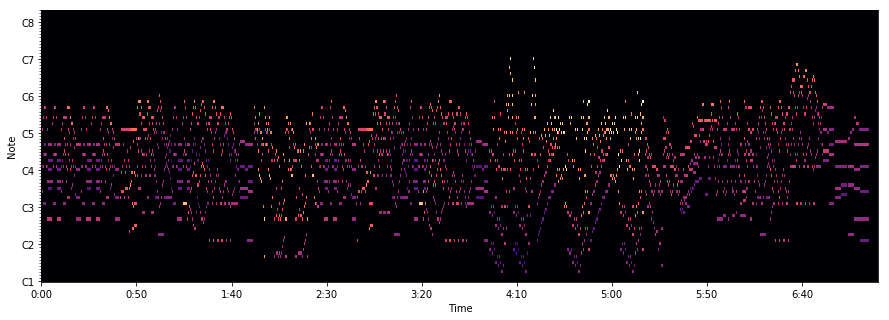

In [70]:
midi_m = prep.pretty_midi.PrettyMIDI('D:\School\Bc\model\MAPS\AkPnBcht\MUS\MAPS_MUS-scn16_2_AkPnBcht.mid')
midi_m = midi_m.get_piano_roll(fs=c.FRAME_LENGTH)[c.MIDI_MIN:c.MIDI_MAX+1, :]
prep.mp.plot_piano_roll(midi_m)

In [6]:
# cqt_m = prep.ap.cqt_matrix('D:\School\Bc\model\MAPS\AkPnBsdf\MUS\MAPS_MUS-alb_se3_AkPnBsdf.wav')
cqt_m = prep.ap.cqt_matrix('D:\School\Bc\model\MAPS\AkPnBcht\MUS\MAPS_MUS-alb_se3_AkPnBcht.wav')
cqt_m = prep.log_normalization(cqt_m)

In [7]:
cqt_m = prep.ap.cqt_split_to_sequence(cqt_m)

In [8]:
input_sequence = np.array(cqt_m[:1])
input_sequence = input_sequence.reshape(1, 264, 629, 1)

In [9]:
input_sequence.shape

(1, 264, 629, 1)

In [10]:
midi_predicted = model.predict(input_sequence)

(88, 625) (264, 629)


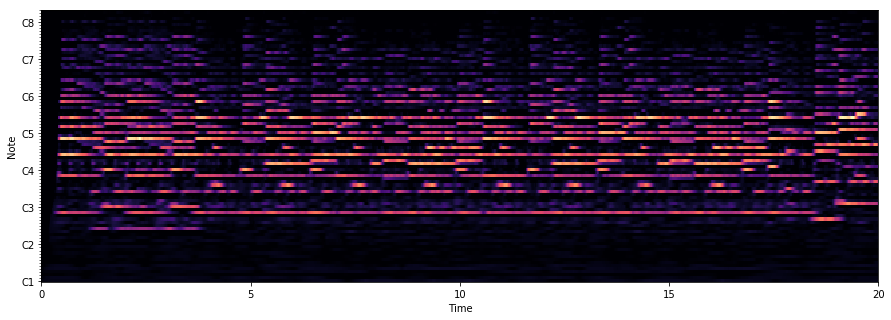

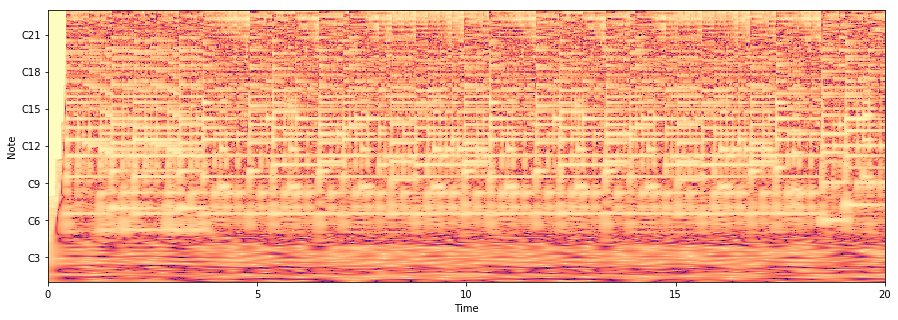

In [11]:
for midi, cqt in zip(midi_predicted, cqt_m[:5]):
    print(midi.shape, cqt.shape)
    prep.mp.plot_piano_roll(midi)
    prep.ap.create_spectrogram(cqt[:, 2:-2])

In [12]:
midi_truncated = [[0 if x < 0.25 else 1 for x in midi] for midi in midi_predicted[0]]

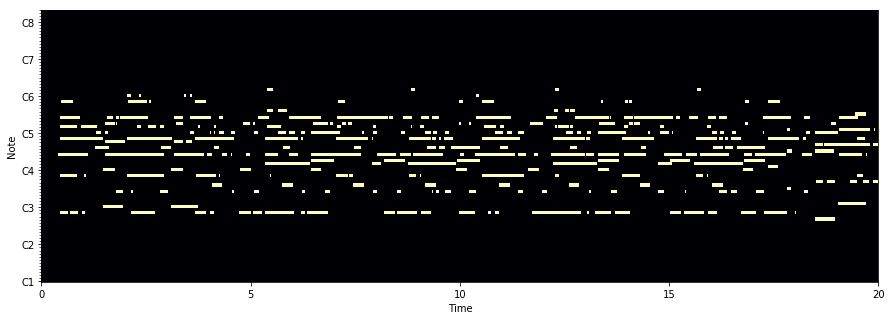

In [13]:
prep.mp.plot_piano_roll(np.array(midi_truncated))

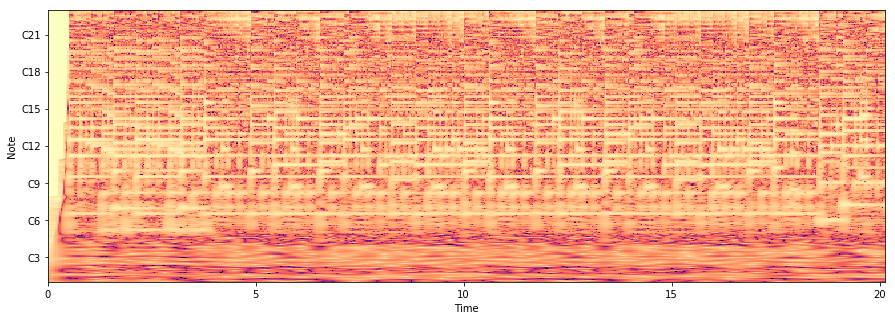

In [14]:
prep.ap.create_spectrogram(cqt_m[0])